In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.special import factorial
import yfinance as yf
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import warnings
warnings.simplefilter("ignore")

In [2]:
def BS_call(sigma, S, K, r, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    d2 = (np.log(S / K) + (r - sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    c = S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    return c

In [3]:
def call_delta(sigma, S, K, r, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    return norm.cdf(d1)

In [4]:
def put_delta(sigma, S, K, r, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    return norm.cdf(d1) - 1

In [5]:
# def get_S(S0, r, lam, sigma, v, delta, T, N=1000):
#     n = np.random.poisson(lam, N)
#     w = np.random.normal(0, T, N)
#     Y = np.array([sum(np.random.normal(v, delta ** 2, i)) for i in n])
#     k = np.exp(v + delta ** 2 / 2) - 1
#     S = S0 * np.exp((r - lam * k - sigma ** 2 / 2) * T + sigma * w + Y)
#     return S

In [6]:
# def get_call_price(r, T, S, K):
#     return np.mean(np.exp(-r * T) * (S - K).clip(min=0))

In [7]:
def get_call_price(S0, r, T, lam, sigma, v, delta, K_list, max_n=1000, tol=0.0000000001):
    n = 0
    res = 0
    for i in range(max_n):
        k = np.exp(v + delta ** 2 / 2) - 1
        lam2 = lam * (1 + k)
        a = np.exp(-lam2 * T) * (lam2 * T) ** n / factorial(n, exact=True)
        if a < tol:
            return res
            break
        sigma_n = np.sqrt(sigma ** 2 + n / T * delta ** 2)
        r_n = r - lam * k + (v + delta ** 2 / 2) * n / T
        c = BS_call(sigma_n, S0, K_list, r_n, T)
        res += a * c
        n += 1
    if a >= tol:
        return res

In [8]:
def get_implied_vol(sigma, *args):
    S, K, r, T, c = args
    return BS_call(sigma, S, K, r, T) - c

In [9]:
# def obj(x, *args):
#     sigma, v, delta = x[0], x[1], x[2]
#     S0, r, lam, T, K_list, spread, implied_vol = args
    
#     S = get_S(S0, r, lam, sigma, v, delta, T)
#     c = np.array([get_call_price(r, T, S, K) for K in K_list])
#     implied_vol2 = fsolve(get_implied_vol, np.ones(len(K_list)), args=(np.mean(S), K_list, r, T, c))
#     err = sum((implied_vol2 - implied_vol) ** 2 / spread)
#     return err

In [10]:
def obj2(x, *args):
    sigma, v, delta = x[0], x[1], x[2]
    S0, r, lam, T, K_list, spread, implied_vol = args
    
    c = get_call_price(S0, r, T, lam, sigma, v, delta, K_list)
    implied_vol2 = fsolve(get_implied_vol, np.ones(len(K_list)), args=(S0, K_list, r, T, c))
    err = sum((implied_vol2 - implied_vol) ** 2 / spread)
    return err

In [11]:
def get_RR_BF(implied_vol, S, K_list, r, T):
    delta_c = call_delta(implied_vol, S, K_list, r, T)
    delta_p = put_delta(implied_vol, S, K_list, r, T)
    sigma_0 = implied_vol[K_list==S]
    condition = (0.265599 <= delta_c) & (delta_p <= 0.744038-1)
    if len(implied_vol[condition])==0:
        RR = 20
        BF = 20
    else:
        sigma_plus, sigma_minus = implied_vol[condition][-1], implied_vol[condition][0]
    
        RR = sigma_plus - sigma_minus
        BF = (sigma_plus + sigma_minus) / 2 - sigma_0
    return RR, BF, sigma_0

In [12]:
def obj(x, *args):
    sigma, v, delta = x[0], x[1], x[2]
    S0, r, lam, T, K_list, RR, BF, sigma_0 = args
    
    c = get_call_price(S0, r, T, lam, sigma, v, delta, K_list)
    implied_vol = fsolve(get_implied_vol, np.ones(len(K_list)), args=(S0, K_list, r, T, c))
    
    RR2, BF2, sigma_02 = get_RR_BF(implied_vol, S0, K_list, r, T)
    
    err = np.mean((RR - RR2) ** 2 +  (BF - BF2) ** 2 / 4 + (sigma_0 - sigma_02) ** 2)
    return err

The following codes are for the stock price/option data

In [13]:
symbol = 'BRK-B'
source = 'yahoo'
start_date = '2017-11-21'
end_date = '2020-11-21'
BRKB = web.DataReader(symbol, source, start_date, end_date)

In [14]:
BRKB

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-11-21,183.500000,181.509995,181.779999,183.179993,3047000,183.179993
2017-11-22,183.779999,181.940002,183.779999,182.559998,3017000,182.559998
2017-11-24,182.979996,182.250000,182.660004,182.360001,1038600,182.360001
2017-11-27,183.869995,182.410004,182.740005,183.490005,2985200,183.490005
2017-11-28,187.839996,184.020004,184.100006,187.539993,3721000,187.539993
...,...,...,...,...,...,...
2020-11-16,233.460007,229.860001,230.580002,233.100006,5766600,233.100006
2020-11-17,234.970001,230.009995,231.929993,233.160004,5038400,233.160004
2020-11-18,234.479996,230.000000,233.570007,230.070007,4740600,230.070007


In [15]:
BRKB_close = BRKB['Adj Close']
S_0 = BRKB_close[-1]
Ret = np.log(BRKB_close/BRKB_close.shift(1))
Ret.dropna(inplace = True)

In [16]:
Ret

Date
2017-11-22   -0.003390
2017-11-24   -0.001096
2017-11-27    0.006177
2017-11-28    0.021832
2017-11-29    0.012242
                ...   
2020-11-16    0.024669
2020-11-17    0.000257
2020-11-18   -0.013341
2020-11-19   -0.002350
2020-11-20   -0.011040
Name: Adj Close, Length: 755, dtype: float64

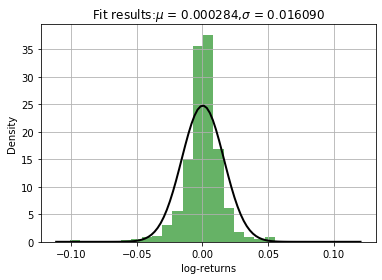

In [17]:
mu, std = norm.fit(Ret)
n_observation_Ret = Ret.size
Ret.plot.hist(grid=True, density = True, bins = round(math.sqrt(n_observation_Ret)), color='g', alpha = 0.6)
plt.xlabel('log-returns')
plt.ylabel("Density")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results:" + r'$\mu$' + " = %f," % mu + r'$\sigma$' + " = %f" % std
plt.title(title)
plt.show()

In [18]:
mu, std

(0.00028413882011328286, 0.016090145822814667)

In [19]:
lamba = sum(1 for i in range(n_observation_Ret)if Ret[i]>=mu+5*std or Ret[i]<=mu-5*std)/3
lamba

1.6666666666666667

In [20]:
option_data = pd.read_excel('Desktop/dataBRKB.xlsx')
option_data = option_data.iloc[63:88,:]
option_data.columns = ['Calls', 'Ticker', 'bids', 'asks', 'Last', 'implied_vol', 'Volume']
r = 0.01
T = 209/365
option_data['Price'] = (option_data['bids'] + option_data['asks']) / 2
get_d = (np.log(S_0/np.array(option_data['Calls'],dtype=float))+(r + (option_data['implied_vol']/100) ** 2/2) * T)/((option_data['implied_vol']/100) * np.sqrt(T))
option_data['Call Delta'] = norm.cdf(np.array(get_d, dtype=float))
option_data

,Calls,Ticker,bids,asks,Last,implied_vol,Volume,Price,Call Delta
63,165,BRKB 6/18/21 C165,63.6,66.4,67.75,32.2206,0,65,0.927021
64,170,BRKB 6/18/21 C170,58.95,61.75,56.98,31.5173,0,60.35,0.912427
65,175,BRKB 6/18/21 C175,54.35,56.95,38.65,29.5983,0,55.65,0.903086
66,180,BRKB 6/18/21 C180,50.25,52.15,55.67,29.4569,0,51.2,0.880626
67,185,BRKB 6/18/21 C185,45.7,48.1,46.05,28.386,0,46.9,0.861428
68,190,BRKB 6/18/21 C190,41.45,43.65,47.28,27.7702,0,42.55,0.836268
69,195,BRKB 6/18/21 C195,37.95,39.1,39.23,26.9421,0,38.525,0.809366
70,200,BRKB 6/18/21 C200,33.85,35,34.7,26.2765,1,34.425,0.777956
71,205,BRKB 6/18/21 C205,29.7,31.25,28.7,25.4359,0,30.475,0.744038
72,210,BRKB 6/18/21 C210,26.2,27.7,27.25,24.9833,12,26.95,0.704298


In [21]:
sigma_0 = 0.223952
sigma_plus = 0.207325
sigma_minus = 0.254359
K_plus = 255
K_minus = 205
RR = sigma_plus - sigma_minus
BF = (sigma_plus + sigma_minus)/2 - sigma_0

given lambda optimize sigma, v, delta

In [22]:
S0 = 227.009995
K_list = np.array([227.009995 + i for i in range(-60, 61, 1)])
r = 0.01
T = 209/365
lam = 1.6666666666666667

In [23]:
args = (S0, r, lam, T, K_list, RR, BF, sigma_0)
x0 = np.array([0.1, -0.03, 0.04])
bnds = ((0, 1), (None, None), (0, None))
res = minimize(obj, x0, args=args, method='SLSQP', bounds=bnds, tol=0.0000001)

In [24]:
res

     fun: 1.6549774414401096e-05
     jac: array([ 4.08173298e-05, -8.50587121e-05, -2.32618738e-04])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.11916426, -0.11249276,  0.11583683])

In [25]:
spread = (option_data['asks'] - option_data['bids']).values

In [26]:
implied_vol = option_data['implied_vol'].values*0.01

In [27]:
implied_vol

array([0.322205925470394, 0.315172864592547, 0.295983260468313,
       0.29456929414918104, 0.28385952743335, 0.277702188077411,
       0.269420801690042, 0.26276526736628003, 0.254359095349089,
       0.24983323379033098, 0.241837325920689, 0.238566784782187,
       0.233564289395348, 0.22395179822024902, 0.22287047898573,
       0.218873246430956, 0.21753245481342098, 0.211653563144179,
       0.207325144289639, 0.20609309346663002, 0.20425061661487,
       0.201694827304974, 0.20300745434908, 0.202914053761969,
       0.203084014482271], dtype=object)

In [28]:
K_list2 = np.array([165 + i*5 for i in range(0, 25)])

In [29]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

Text(0, 0.5, 'implied_vol')

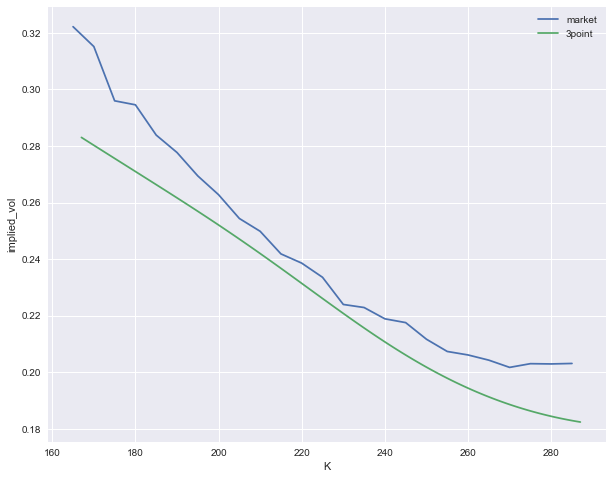

In [30]:
sigma, v, delta = res.x[0], res.x[1], res.x[2]
c1 = get_call_price(S0, r, T, lam, sigma, v, delta, K_list)
implied_vol1 = fsolve(get_implied_vol, np.ones(len(K_list)), args=(S0, K_list, r, T, c1))



plt.figure(figsize=(10,8))
plt.plot(K_list2,implied_vol)
plt.plot(K_list,implied_vol1)
plt.legend(['market', '3point'])
plt.xlabel("K")
plt.ylabel("implied_vol")